SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #5: TS Foreasting using ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - stationary TS, ARMA, ARIMA, ARMAX, SARIMAX, exogenious variables, autocorrelcation function, partial autocorrelation function
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [2]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools


from utils import qualityMACAPE, get_autoregrmatrix

%matplotlib inline

# ARIMA Parameters
**Questions**
  * How to make TS stationary?
  * Write down formula that describes how the tranformed ts will look like (use lag operator $\bf B$).

**Answer**
<!-- $${\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)$$
where $s~-$ seasonality period -->


 




## ARIMA model for non-stationary time series
In order to make ts stationary we apply trend ${\bf(1-\bf B)}$ differencing $d$ times and seasonal ${\bf(1-B^s)}$ differencing $D$ times.


**Main hypothesys**: exists $d$, $D$, $\lambda$ such that
  
  * $$ {\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)~- \text{ stationary} $$ 


Final ts model:
* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}z_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}(z_t-\mu) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

In [ ]:
a# Wage
ts_wage = pd.read_csv('../1_ts_esm/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts_wage = ts_wage.sort_index() # sort index
ts_wage.head()

,Real wage
Timestamp,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


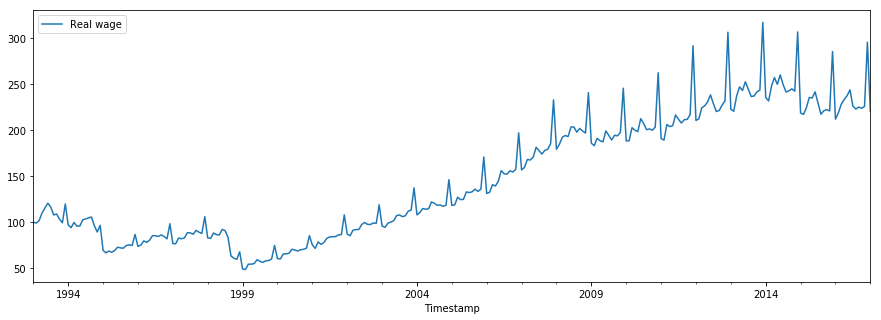

In [ ]:
ts_wage.plot(figsize=(15,5))

** Questions:**
  - Which components of TS do you see?
  - Are there any dependences on other variables?
  - Is that TS stationary? Why?

## Parameters of ARIMA model

Classic form of ARIMA model implies that there are some seasonal Autoregression and Moving Average Components


$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}y_t = \underbrace{c+\sum_{i=1}^{\color{red}p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\underbrace{\sum_{l=1}^{\color{red}P} \delta_ly_{t-\color{red}{s\cdot l}}}\limits_{seasonal~AR}+\underbrace{\sum_{m=1}^{\color{red}Q} \beta_j\varepsilon_{t-\color{red}{s*m}}}\limits_{seasonal~MA}+\varepsilon_t$$


Classic ARIMA model is discribed with 6 parameters:
$$ARIMA(p, d, q)\times(P, D, Q)_s$$
where

 - $p~-$ is a number of non-seasonal AR components
 - $q~-$ is a number of non-seasonal MA components
 - $d~-$ is a number of trend-differencing applied to make ts stationary
 - $P~-$ is a number of seasonal AR components
 - $Q~-$ is a number of seasonal MA components
 - $D~-$ is a number of seasonal-differencing to make ts stationary

In [ ]:
# ts = pd.read_csv('data/TimeSeries_Data10.csv', sep=',', decimal='.',parse_dates={'Timestamp': pd.to_datetime(['Dates'],dayfirst=True, errors='coerce')}, index_col='Timestamp')
ts = pd.read_csv('../1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index
ts.head()

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2005-01-11,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-12,NaN,5.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-13,NaN,2.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-14,NaN,42.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-15,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


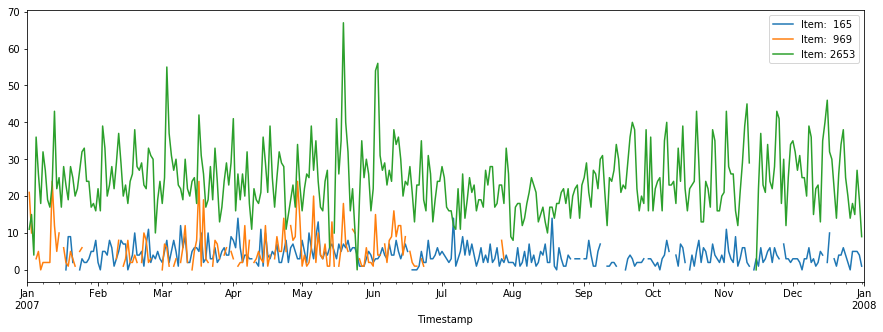

In [ ]:
# fig = plt.figure()
ts.loc['2007-01-01':'2008-01-01', ts.columns[range(3)]].plot(figsize=(15,5))
# to save the pictures
# plt.savefig('../Lecture_TS_Forecasting/pic/TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

** Questions:**
  - Which components of TS do you see?
  - Are there any dependences on other variables?
  - Is that TS stationary? Why?

## Energy Consumption

In [ ]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter only Hub=Center and ZSP=FZSZOE27
energy_ts= energy_ts[(energy_ts['ZSP']=='FZSZOE27') & (energy_ts['Hub']=='Center')]
energy_ts.tail()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2015-05-23,Center,FZSZOE27,NaN,11.7,11.9,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-24,Center,FZSZOE27,NaN,12.4,12.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,Center,FZSZOE27,NaN,16.2,15.4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-26,Center,FZSZOE27,NaN,18.7,17.3,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-27,Center,FZSZOE27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


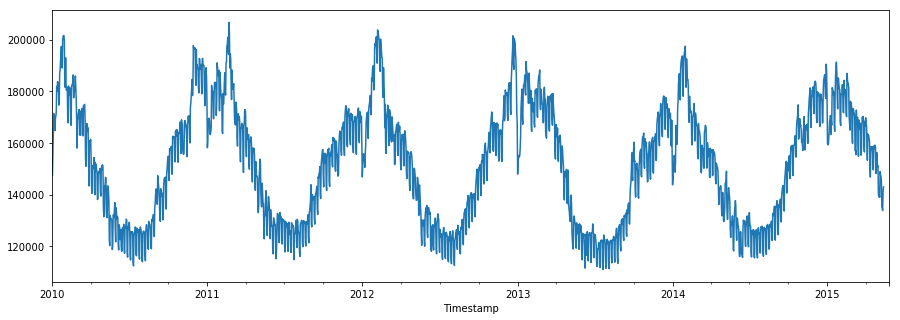

In [ ]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot(figsize=(15,5))

# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_YearSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions** 
    - Which components of TS do you see?
    - Are there any dependences on other variables?
    - Is that TS stationary? Why?

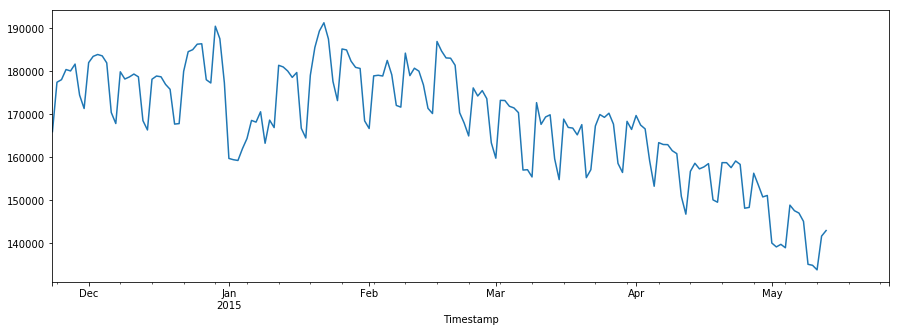

In [ ]:
# See Week easonality
energy_ts['EnergyConsump'].tail(186).plot(figsize=(15,5))

In [ ]:
# re_energy = week_reshaping(energy_ts[['EnergyConsump']])
week_df = pd.DataFrame(index = energy_ts.index, columns = {'EnergyConsump', 'dayofweek', 'weekno'})
week_df['EnergyConsump'] = energy_ts['EnergyConsump']
week_df['dayofweek'] = week_df.index.dayofweek
week_df['weekno'] = week_df.index.week
week_df.head(10)

,dayofweek,EnergyConsump,weekno
Timestamp,,,
2010-01-01,4,147487.171,53
2010-01-02,5,155433.800,53
2010-01-03,6,164140.232,53
2010-01-04,0,171382.848,1
2010-01-05,1,170188.290,1
2010-01-06,2,168969.315,1
2010-01-07,3,164772.821,1
2010-01-08,4,169338.900,1
2010-01-09,5,170479.031,1


In [ ]:
week_df[365:370]

,dayofweek,EnergyConsump,weekno
Timestamp,,,
2011-01-01,5,158153.590,52
2011-01-02,6,160830.667,52
2011-01-03,0,166612.579,1
2011-01-04,1,169195.014,1
2011-01-05,2,169586.189,1


** Practice:** plot dependence energy comsumption volume on dayofweek (use pandas.pivot)

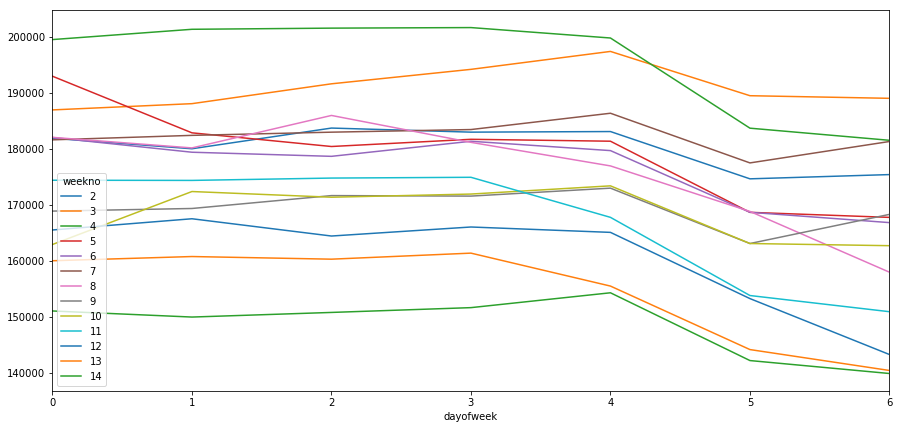

In [ ]:
#  put your code here
week_df.loc['2010-01-11':'2010-04-11'].pivot(index='dayofweek', columns='weekno', values='EnergyConsump').plot(figsize=(15,7))

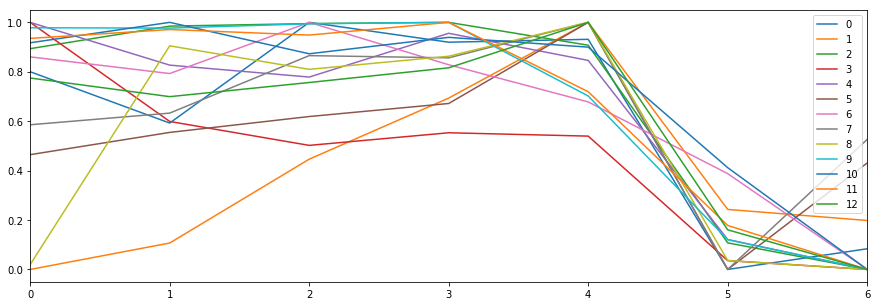

In [ ]:
# to normalize values
from sklearn import preprocessing

x = week_df.loc['2010-01-11':'2010-04-11'].pivot(index='dayofweek', columns='weekno', values='EnergyConsump').values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pd.DataFrame(x_scaled).plot(figsize=(15,5))

In [ ]:
x

array([[ 171382.848,  181911.973,  186963.706,  199519.915,  192978.715,
         182040.772,  181622.161,  182065.997,  168901.444,  162939.769,
         174411.451,  165530.764,  160037.652],
       [ 170188.29 ,  180030.26 ,  188079.82 ,  201355.854,  182872.053,
         179410.528,  182420.084,  180178.829,  169367.466,  172394.201,
         174379.353,  167533.792,  160790.43 ],
       [ 168969.315,  183723.37 ,  191623.055,  201561.554,  180431.961,
         178677.214,  182990.347,  185975.674,  171667.636,  171377.559,
         174797.424,  164451.576,  160319.138],
       [ 164772.821,  182995.363,  194204.024,  201661.804,  181718.532,
         181368.222,  183458.436,  181173.608,  171578.765,  171943.98 ,
         174935.994,  166063.118,  161397.525],
       [ 169338.9  ,  183101.294,  197404.312,  199801.036,  181376.855,
         179700.799,  186369.872,  176967.072,  172998.363,  173409.064,
         167785.171,  165103.494,  155516.519],
       [ 170479.031,  174661.5

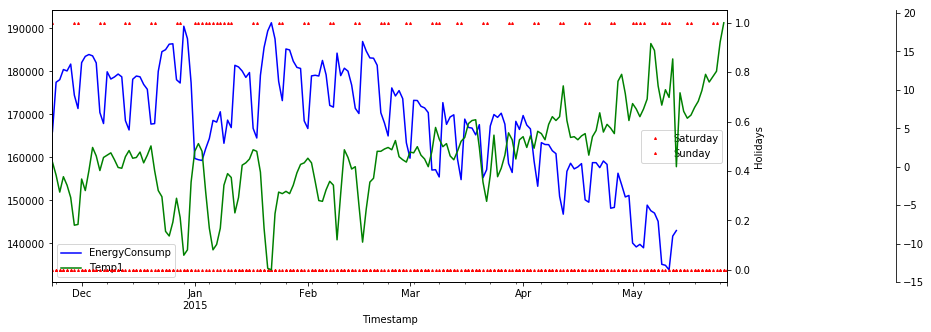

In [ ]:
# See dependence on other varibales
fig, ax = plt.subplots(figsize=(15,5))
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

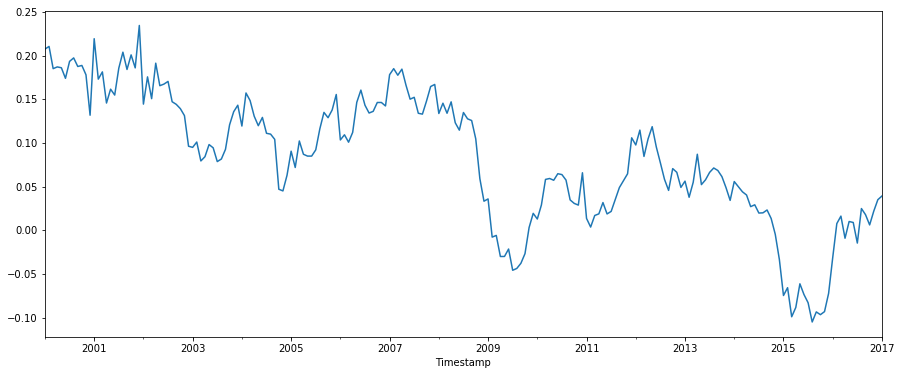

In [ ]:
# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_wage_boxcox.plot(figsize=(15,6))

** Questions:**
   * Is that TS stationary?

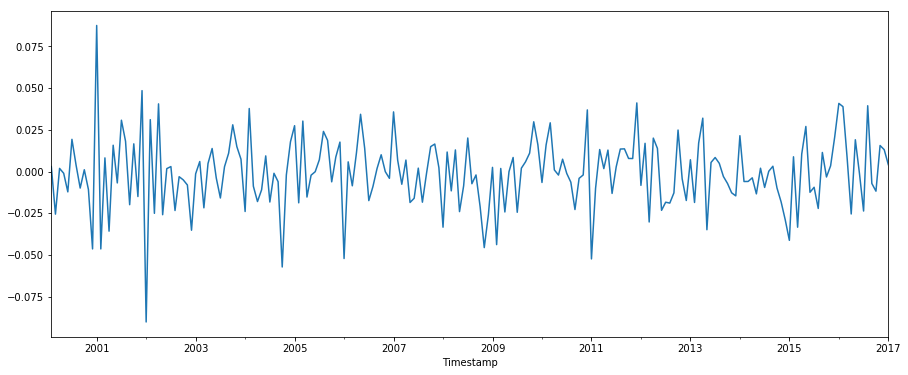

In [ ]:
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot(figsize=(15,6))

** Questions:**
   * Is that TS stationary?
   * How to check it? (Which statistical tests do you know?)

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.062453, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [ ]:
# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -5.227607, 
pvalue: 0.00 
maximal Lag: 11 
critical values: {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.5748586990017359}


<h1 align="center"> ARIMA family models </h1>

# ARIMA model and Stationarity
$$y_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iy_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

or in canonical form (using back-operator $B$):

$$\phi\left(B\right)(y_t-\mu) = \theta\left(B\right)\varepsilon_t.$$

$\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

** Question: **
   * What is $\phi\left(B\right)$ and $\theta\left(B\right)$?
    
    

** Questions: **
  * Write down equation in canonical form for next TS:
       - 1) $y_t ={y_{t-1}} + 1 +\varepsilon_t$
       - 2) $y_t =y_{t - p} +\varepsilon_t$, where $p>1$ - period of seasonality
  
    <Answer>
   
* Show that $\phi(B)$ in equations above has unit roots.
   
   <Answer>
   
* Explain why linear operator $1-B$ is not invertable 
       Hint:
       - 1) show that back operator $B$ is a linear operator with norm 1;
       - 2) use the fact that if $||A||=1\Rightarrow $(1-A)$ is not invertable
* Why ARMA model works only with stationary TS? 

# ARMA for forecasing Retail Time Series

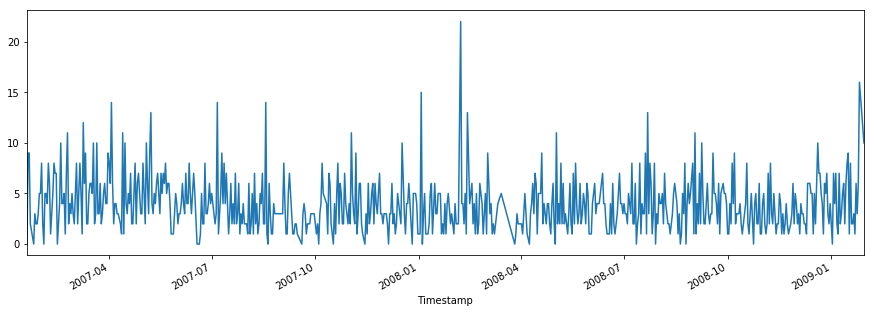

In [ ]:
# удаляем пропуски: иначе нельзя
dta = ts[ts.columns[0]].dropna()
dta.plot(figsize=(15,5))

In [ ]:
# test for stationarity
kpss_stat= stattools.kpss(np.array(dta))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.509193, 
pvalue: 0.04 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


It can be assumed that TS is stationary

** Question **
   * How to choose parameters $p$ and $q$ for ARMA model?

## Autocorrelation analysis

** Questions **
    * What is autocorrelation function (ACF)?
    * What does coefficient of correlation show?
    * What is partial autocorrelation function (PACF)?  What does coefficient of partial correlation show?
    * How do ACF and PACF help to choose p and q of ARMA model?
    
    
**Autocorrelation coeficient:**
### $$ r_\tau = r_{y_t y_{t+\tau}} = \frac{\sum\limits_{t=1}^{T-\tau} \left(y_t - \bar{y}\right)\left(y_{t+\tau} - \bar{y}\right) }{ \sum\limits_{t=1}^T \left(y_t - \bar{y}\right)^2 },\;\; \bar{y} = \frac1{T} \sum_{t=1}^T y_t.$$
		
$r_\tau \in\left[-1,1\right], \;\; \tau$ - autocorrelation lag.

** Coefficient of partial correlation:** between $y$, $x_1$ excluding dependence on $x_2$:

<img src='https://github.com/aromanenko/ATSF/blob/wip/pic/PACF.png?raw=1'>

<span style="color:red">Coefficient of partial correlation</span> shows correlation between $y_t$ and $y_{t-k}$, <span style="color:red">excluding dependence on </span>
   - $y_t$ ($y_{t-k}$)  and $y_{t-1}$
   - $y_t$ ($y_{t-k}$) and $y_{t-2}$
   
   ...
   
   - $y_t$ ($y_{t-k}$) and $y_{t-(k-1)}$    


**Main rule **: 
   * $q$: the number of the last lag $\tau<S$ at which <span style="color:red"> ACF </span> was significant ($S$ - period of seasonality)
   * $p$: the number of the last lag $\tau<S$ at which <span style="color:red">PACF</span> was significant

Example1 : ACF and PACF for AR(1) model
<img src='https://github.com/aromanenko/ATSF/blob/wip/pic/AR1.png?raw=1'>

Example2 : ACF and PACF for AR(2) model
<img src='https://github.com/aromanenko/ATSF/blob/wip/pic/AR2.png?raw=1'>


Example3 : ACF and PACF for MA(1) model
<img src='https://github.com/aromanenko/ATSF/blob/wip/pic/MA2_1.png?raw=1'>


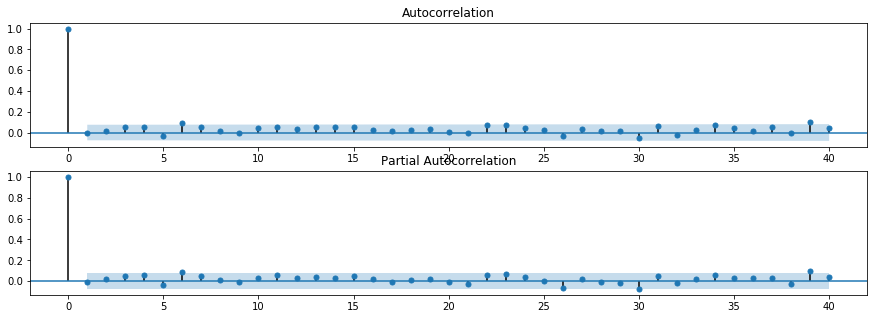

In [ ]:
# Use Item 165
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

* try just simple ARMA models (p=0, q=0)

In [ ]:
arma_mod00 = sm.tsa.ARMA(dta, (0,0)).fit()
print(arma_mod00.params)
print(arma_mod00.aic, arma_mod00.bic, arma_mod00.hqic)

Series([], dtype: float64)
3299.63826265 3308.69417849 3303.14263934


In [ ]:
arma_mod01 = sm.tsa.ARMA(dta, (0,1)).fit()
print(arma_mod01.params)
print(arma_mod01.aic, arma_mod01.bic, arma_mod01.hqic)

const               3.910795
ma.L1.Item:  165   -0.006996
dtype: float64
3301.603847883614 3315.18772164 3306.86041291


In [ ]:
arma_mod10 = sm.tsa.ARMA(dta, (1,0)).fit()
print(arma_mod10.params)
print(arma_mod10.aic, arma_mod10.bic, arma_mod10.hqic)

const               3.910796
ar.L1.Item:  165   -0.007255
dtype: float64
3301.602584786089 3315.18645854 3306.85914981


## Analyse Residuals to proof the model

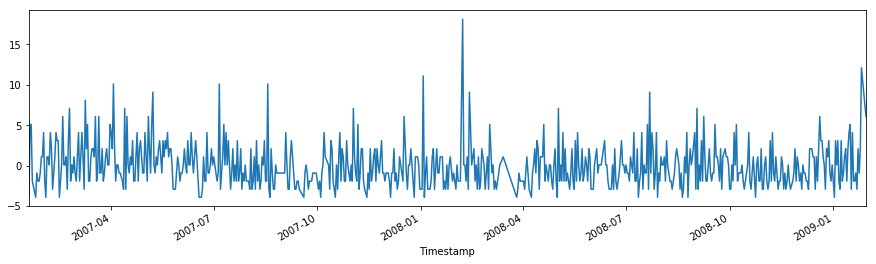

In [ ]:
# plot residuals
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = arma_mod00.resid.plot(ax=ax, figsize=(15,4));

### Stationarity test

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arma_mod00.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.509193, 
pvalue: 0.04 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


It can be assumed that TS is stationary

### Autocorrelation test

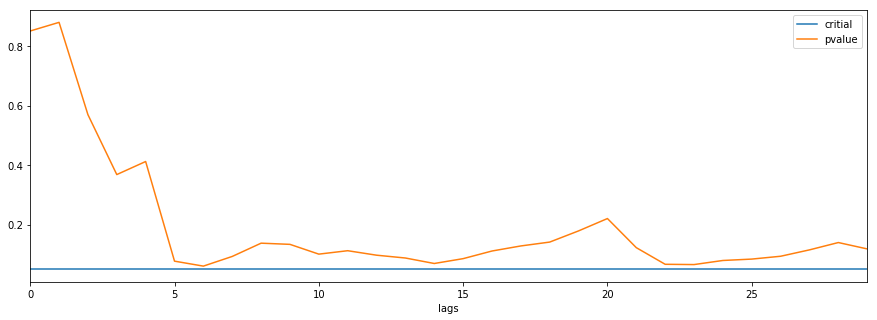

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Values of the TS are not correlated

### Unbiasedness test

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arma_mod00.resid.values)

2.0038098857004782

In [ ]:
stat = stats.wilcoxon(arma_mod00.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 112078.000000
pvalue: 0.33


Residuals are not biased!

### Normality test

In [ ]:
stats.normaltest(arma_mod00.resid)

NormaltestResult(statistic=212.46951827279702, pvalue=7.2917256619287168e-47)

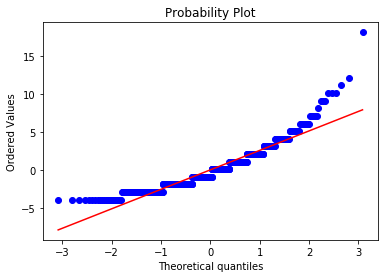

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arma_mod00.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

### Forecast of Validation Period

In [ ]:
frc_arma = arma_mod01.predict('2008-12-30', '2008-12-31', dynamic=False)
print(frc_arma)

Timestamp
2008-12-30    3.917016
2008-12-31    3.924208
dtype: float64


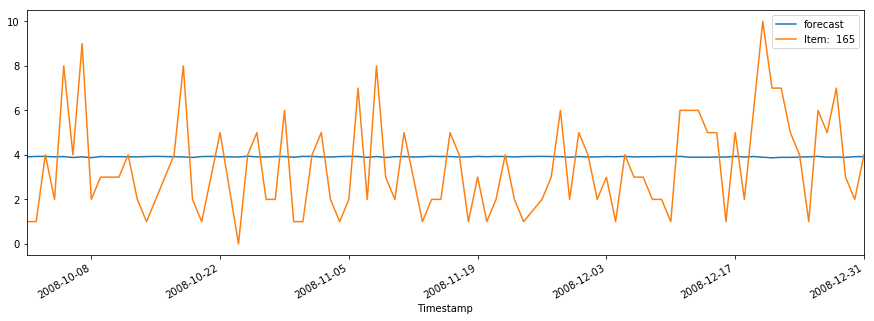

In [ ]:
fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arma_mod01.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax)

### Forecast of Future Period

In [ ]:
frc_arma = arma_mod01.forecast(steps=185)
print(frc_arma[1])

[ 2.69158051  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639  2.69164639
  2.69164639  2.69164639  2.69164639  2.69164639  2

# ARIMA

** Модель временного ряда ARIMA**


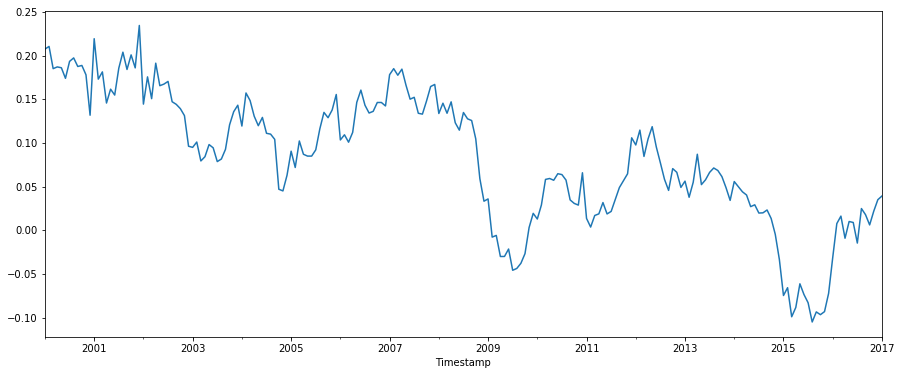

In [ ]:
# Forecast sdiff_ts_wage_boxcox
sdiff_ts_wage_boxcox.plot(figsize=(15,6))

* We already know that after differencing TS is stationary => $d=1$
* Let's try find $p$ and $q$ (look at ACF and PACF <span style="color:red"> after differencing</span>)

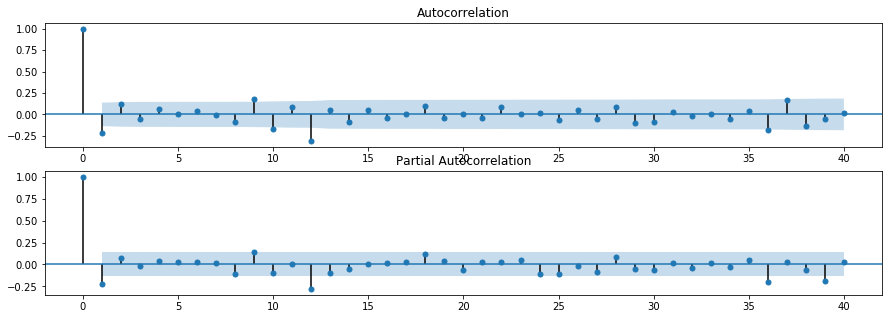

In [ ]:
# Use Item 165
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox.values.squeeze(), lags=40, ax=ax2)

* **candidates values for q (according to ACF)** - 1, 9, 10 (don't look at 12 or greater: it's larger than period of seasonality)
* **candidates values for p (according to PACF)** - 1, 9 (don't look at 12 or greater: it's larger than period of seasonality)

In [ ]:
## Choosing best model accoridng to AIC criterion
arima_mod111 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,1)).fit()
print(arima_mod111.params)
print(arima_mod111.aic, arima_mod111.bic, arima_mod111.hqic)

const                 -0.000834
ar.L1.D.wage_boxcox   -0.539578
ma.L1.D.wage_boxcox    0.337118
dtype: float64
-991.4569907187226 -978.184510743 -986.088031868


In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod119 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,9)).fit()
print(arima_mod119.params)
print(arima_mod119.aic, arima_mod119.bic, arima_mod119.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arma_mod1110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (1,1,10)).fit()
print(arima_mod1110.params)
print(arima_mod1110.aic, arima_mod1110.bic, arima_mod1110.hqic)

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod911 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,1)).fit()
print(arima_mod911.params)
print(arima_mod911.aic, arima_mod911.bic, arima_mod911.hqic)

const                 -0.000846
ar.L1.D.wage_boxcox   -0.909261
ar.L2.D.wage_boxcox   -0.066992
ar.L3.D.wage_boxcox    0.047736
ar.L4.D.wage_boxcox    0.039425
ar.L5.D.wage_boxcox    0.058467
ar.L6.D.wage_boxcox    0.068016
ar.L7.D.wage_boxcox    0.006379
ar.L8.D.wage_boxcox   -0.082354
ar.L9.D.wage_boxcox    0.073923
ma.L1.D.wage_boxcox    0.761500
dtype: float64
-988.2653500338749 -948.447910108 -972.158473483


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod919 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,9)).fit()
print(arima_mod919.params)
print(arima_mod919.aic, arima_mod919.bic, arima_mod919.hqic)

const                 -0.000976
ar.L1.D.wage_boxcox   -0.150403
ar.L2.D.wage_boxcox    0.519736
ar.L3.D.wage_boxcox    0.275666
ar.L4.D.wage_boxcox    0.275282
ar.L5.D.wage_boxcox   -0.024404
ar.L6.D.wage_boxcox   -0.182132
ar.L7.D.wage_boxcox   -0.598245
ar.L8.D.wage_boxcox   -0.227851
ar.L9.D.wage_boxcox    0.698578
ma.L1.D.wage_boxcox   -0.049985
ma.L2.D.wage_boxcox   -0.570083
ma.L3.D.wage_boxcox   -0.284679
ma.L4.D.wage_boxcox   -0.279555
ma.L5.D.wage_boxcox    0.281655
ma.L6.D.wage_boxcox    0.261406
ma.L7.D.wage_boxcox    0.597745
ma.L8.D.wage_boxcox   -0.007092
ma.L9.D.wage_boxcox   -0.943805
dtype: float64
-1004.279374514849 -937.916974638 -977.434580264


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
## Choosing best model accoridng to AIC, BIC criteria
arima_mod9110 = sm.tsa.ARIMA(sdiff_ts_wage_boxcox, (9,1,10)).fit()
print(arima_mod9110.params)
print(arima_mod9110.aic, arima_mod9110.bic, arima_mod9110.hqic)

const                  -0.000956
ar.L1.D.wage_boxcox    -0.332327
ar.L2.D.wage_boxcox     0.485708
ar.L3.D.wage_boxcox     0.249135
ar.L4.D.wage_boxcox     0.163675
ar.L5.D.wage_boxcox     0.128084
ar.L6.D.wage_boxcox    -0.110585
ar.L7.D.wage_boxcox    -0.600725
ar.L8.D.wage_boxcox    -0.135955
ar.L9.D.wage_boxcox     0.660917
ma.L1.D.wage_boxcox     0.111328
ma.L2.D.wage_boxcox    -0.665728
ma.L3.D.wage_boxcox    -0.238999
ma.L4.D.wage_boxcox    -0.057646
ma.L5.D.wage_boxcox     0.075386
ma.L6.D.wage_boxcox     0.261861
ma.L7.D.wage_boxcox     0.663913
ma.L8.D.wage_boxcox    -0.231085
ma.L9.D.wage_boxcox    -0.951199
ma.L10.D.wage_boxcox    0.034378
dtype: float64
-995.7245159431063 -926.043996072 -967.537481979


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



* According to AIC criterion arma_mod919 is best of this 6 models

## Analyse Residuals to proof the model arima_mod919

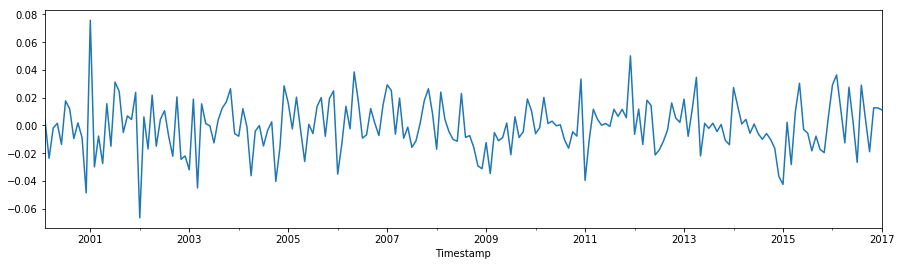

In [ ]:
# plot residuals
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = arima_mod919.resid.plot(ax=ax, figsize=(15,4));

### Stationarity test

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod919.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.066837, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



It can be assumed that TS is stationary

### Autocorrelation test

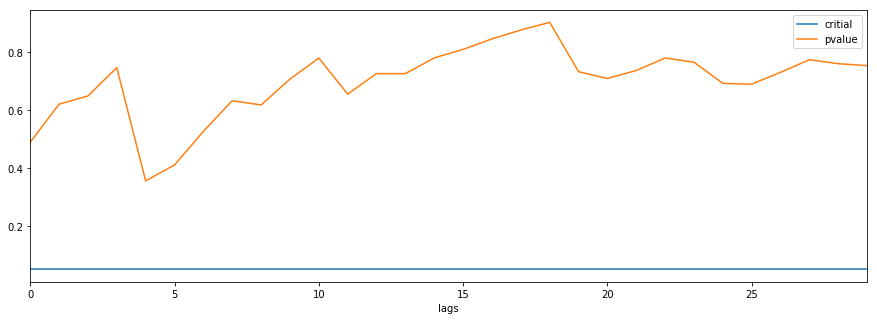

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod919.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot(figsize=(15,5))
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Values of the TS are not correlated

### Unbiasedness test

In [ ]:
# Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod919.resid.values)

2.0933382031995951

In [ ]:
stat = stats.wilcoxon(arima_mod919.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 10183.000000
pvalue: 0.75


Residuals are not biased!

### Normality test

In [ ]:
stats.normaltest(arima_mod919.resid)

NormaltestResult(statistic=7.8255229140452771, pvalue=0.01998523641987569)

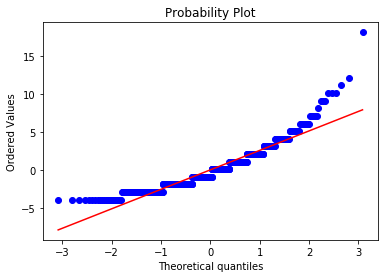

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arma_mod00.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

<h1 align="center"> Practice </h1>

# Practice: Realize Box-Cox transformation

As you've seen boxcox transformation from scipy does not work well.
It's suggested to realize method for searching optimal $\lambda$ for boxcox transformation.
Approach for finding the optimal $\lambda$ is descibed <a href="file:///C:/Users/rusrom/Downloads/Guerrero_JoF1993.pdf">here</a>.  

You need to replace all 'TODO' below by some code:

In [ ]:
import numpy as np

class boxcox():
    def __init__(self, lmbda=None, shift=0):
        '''
        Box Cox Transforms
        Transforms data are to be normal. Also known as power transform.

        Parameters
            ----------
        lmbda: float or None
            lmbda the power parameter. The None input automatically calculates
            lmbda based on method guerrero
        shift: float
            Use to normalize data by shifting data to all positive values
        
        '''
        self.lmbda = lmbda
        self.shift = shift
        self.y = []
        self.method = 'guerrero'
        
    def transform(self, x, n=2):
        '''
            x: time series
            n: number of subseries with constant dispersion
        '''
        x = 1.0 * np.asarray(x)
        
        if self.shift>0:
            x= x + self.shift
            
        if self.lmbda is None:
            self.lmbda = self.optimal_lambda(x,n) 
            
        
        if self.lmbda == 0:
            self.y = np.log(x)
        else:
            self.y = (x**self.lmbda - 1)/self.lmbda
        
        return self.y, self.lmbda
        
    def optimal_lambda(self,x, n=2):
        """
        Parameters
        ----------
        x - time series with different variance through the time
        n - number of subseries in x, each subseries x_i has constant variance sigma_i and constant mean m_i
        The method states, that optimal lambda should be chosen in such a way that
         
         sigma_i/(m_i)**(1-lambda) = constant, for all i=1,...,n
        
        you need to find solution for the follow Regression problem:
        
        log(sigma_i) = w_1 + w_2*log(m_i), where
        w_2 = 1-lambda
        
        """
        x = 1.0*np.asarray(x)
        x_parts = np.array_split(x, n)
               
        sigma = np.ones(n)
        m = np.ones(2 * n).reshape(2,n)

        r = len(x)/n  

        for i in range(n):
            m[1][i] = np.log(np.mean(x_parts[i]))
            sigma[i] = np.log(np.var(x_parts[i]))/2 
        w = np.dot(np.linalg.inv(np.dot(m,m.T)),np.dot(m,sigma))
        self.lmbda = 1-w[1]
        
        
        return self.lmbda

    def inverse(self, y=None):
        """
        Parameters
        ----------
        y: time series

        Returns
        -------
        x: inverse transformed ts
    
        """
        if y is None:
            y = self.y
        
        if self.lmbda == 0:
            x = np.exp(y)
        else:
            x = (self.lmbda * y + 1) ** (1/self.lmbda)
        return x        

## Check your solution on wage data

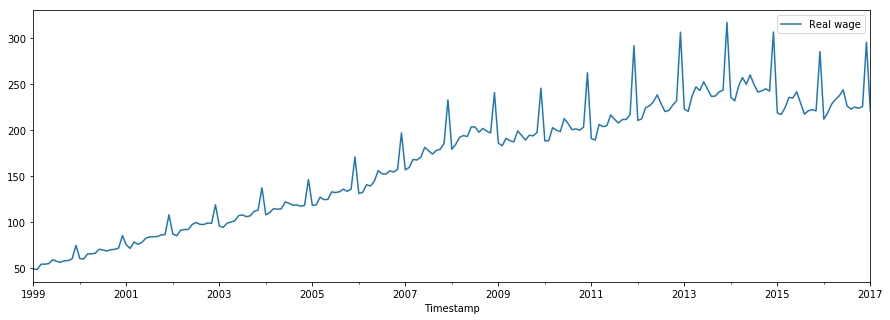

In [ ]:
ts_wage[['Real wage']].plot(figsize=(15,5))

lambda= 0.0532178007927


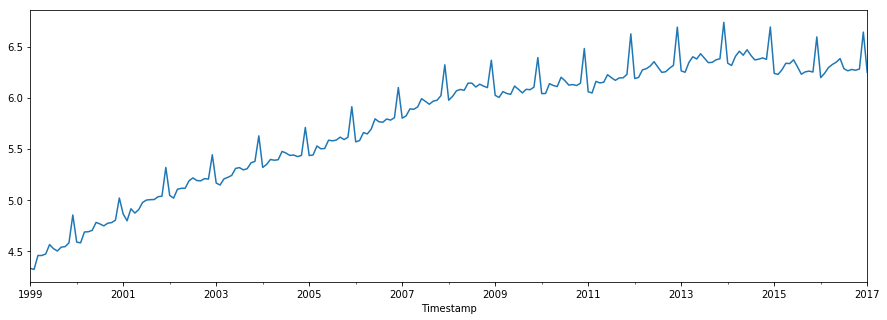

In [ ]:
bc = boxcox()
ts_wage['wage_boxcox'], lmbda = bc.transform(ts_wage['Real wage'],n=18)
print ('lambda=', lmbda)
ts_wage['wage_boxcox'].plot(figsize=(15,5))

* The optimal lambda is near to zero

# ES models are subset of ARIMA models

ARIMA contains all ES models with linear trend and additive seasonality

   * ARIMA(p=0,d=1,q=1) is equivalent to Simple ES with
###     $$(1-B)y_t = (1-\phi_1 B)\varepsilon_t$$
###    $$\phi_1 = 1-\alpha$$

Proof:
###    $$y_t-y_{t-1} = \varepsilon_t-\phi_1 \varepsilon_{t-1}=y_t-\hat{y}_t - (1-\alpha)\cdot (y_{t-1}-\hat{y}_{t-1}) $$
    
###    $$\hat{y}_t= y_{t-1} - y_{t-1}+\alpha y_{t-1} + (1-\alpha)\cdot\hat{y}_{t-1}={\hat{y}_{t-1}+\alpha\cdot e_{t-1}}$$

   * ARIMA(p=0,d=2, q=2) is equivalent to Holt (linear trend) with:
###    $$(1-B)^2Y_t = (1-\phi_1 B-\phi_2 B^2)\varepsilon_t$$
###    $$\phi_1 = 2-\alpha-\alpha\beta, \text{ }\phi_2 = \alpha-1$$
	

   * Damped-trend linear exponential smoothing is the ARIMA(1,1,2) model
### 		$$(1-\phi B)(1-B)Y_t = (1-\theta_1 B-\theta_2 B^2)\epsilon_t$$
### 		$$\theta_1 = 1+\phi-\alpha-\alpha\beta\phi, \text{ } \theta_2 = (\alpha-1)\phi$$
        $\phi$ - coefficient of damped trend;

# Online forecasting with ARIMA

In [ ]:
def myARMA(x, h, Params): # see statsmodels.ARMA
    
    # Параметры алгоритма
    p = Params['p']
    q = Params['q']
    
    start = ts.index[-1]+timedelta(1)
    end = ts.index[-1]+timedelta(h)
    rng = pd.date_range(start, end)
    frc_ts = pd.Series(index = x.index.append(rng))

    for t in range(len(x.index)): #
#         y = pd.Series(index = x.index[:t+1]
        y = x[:t+1]
        if not y.dropna().empty:
    #        return frc_ts
    #    else:
            try:
                arma_mod = sm.tsa.ARMA(y.dropna(), (p,q)).fit()
#                 frc_ts[t+h-1] = arma_mod.predict(start = y.index[-1]) # get last forecasting value
                frc_ts[t+h-1] = arma_mod.forecast(steps = h)[-1] # get last forecasting value
            except Exception:
                print("Can not fit model p=%d, q=%d at step t=%d!" % (p, q, t))
        
    # Извлекаем прогноз
    #start = notnan_x.index[0].to_datetime().strftime("%Y-%m-%d")
    #end = notnan_x.index[len(notnan_x)-1].to_datetime().strftime("%Y-%m-%d")

    return frc_ts.ffill()

In [ ]:
# Caution: takes a lot of time

P = [1]
h = 1
q = 0
ts_num = 4

for p_cntr in P:
    frc_ts = pd.DataFrame(index = ts.index.append(rng))
    Params ={'p':p_cntr, 'q': q}
    for ts_num in ts.columns[4]:
        x = ts[ts_num]
        frc_ts[ts_num] = myARMA(x, h, Params)
    FRC_TS['ARMA p={1}, q={0}'.format(p_cntr,q)] = frc_ts

Can not fit model p=1, q=0 at step t=721!
Can not fit model p=1, q=0 at step t=722!
Can not fit model p=1, q=0 at step t=732!
Can not fit model p=1, q=0 at step t=733!
Can not fit model p=1, q=0 at step t=734!
Can not fit model p=1, q=0 at step t=735!
Can not fit model p=1, q=0 at step t=736!
Can not fit model p=1, q=0 at step t=741!
Can not fit model p=1, q=0 at step t=742!
Can not fit model p=1, q=0 at step t=751!
Can not fit model p=1, q=0 at step t=779!
Can not fit model p=1, q=0 at step t=810!
Can not fit model p=1, q=0 at step t=840!
Can not fit model p=1, q=0 at step t=871!
Can not fit model p=1, q=0 at step t=887!
Can not fit model p=1, q=0 at step t=901!
Can not fit model p=1, q=0 at step t=932!
Can not fit model p=1, q=0 at step t=958!
Can not fit model p=1, q=0 at step t=962!
Can not fit model p=1, q=0 at step t=963!
Can not fit model p=1, q=0 at step t=971!
Can not fit model p=1, q=0 at step t=972!
Can not fit model p=1, q=0 at step t=978!
Can not fit model p=1, q=0 at step

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=163!
Can not fit model p=1, q=0 at step t=165!
Can not fit model p=1, q=0 at step t=166!
Can not fit model p=1, q=0 at step t=167!
Can not fit model p=1, q=0 at step t=168!
Can not fit model p=1, q=0 at step t=172!
Can not fit model p=1, q=0 at step t=174!
Can not fit model p=1, q=0 at step t=177!
Can not fit model p=1, q=0 at step t=178!
Can not fit model p=1, q=0 at step t=179!
Can not fit model p=1, q=0 at step t=180!
Can not fit model p=1, q=0 at step t=181!
Can not fit model p=1, q=0 at step t=183!
Can not fit model p=1, q=0 at step t=187!
Can not fit model p=1, q=0 at step t=188!
Can not fit model p=1, q=0 at step t=190!
Can not fit model p=1, q=0 at step t=191!
Can not fit model p=1, q=0 at step t=192!
Can not fit model p=1, q=0 at step t=193!
Can not fit model p=1, q=0 at step t=195!
Can not fit model p=1, q=0 at step t=196!
Can not fit model p=1, q=0 at step t=197!
Can not fit model p=1, q=0 at step t=198!
Can not fit model p=1, q=0 at ste

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=891!
Can not fit model p=1, q=0 at step t=894!
Can not fit model p=1, q=0 at step t=895!
Can not fit model p=1, q=0 at step t=896!
Can not fit model p=1, q=0 at step t=898!
Can not fit model p=1, q=0 at step t=899!
Can not fit model p=1, q=0 at step t=902!
Can not fit model p=1, q=0 at step t=907!
Can not fit model p=1, q=0 at step t=908!
Can not fit model p=1, q=0 at step t=909!
Can not fit model p=1, q=0 at step t=910!
Can not fit model p=1, q=0 at step t=911!
Can not fit model p=1, q=0 at step t=912!
Can not fit model p=1, q=0 at step t=913!
Can not fit model p=1, q=0 at step t=914!
Can not fit model p=1, q=0 at step t=915!
Can not fit model p=1, q=0 at step t=916!
Can not fit model p=1, q=0 at step t=917!
Can not fit model p=1, q=0 at step t=918!
Can not fit model p=1, q=0 at step t=919!
Can not fit model p=1, q=0 at step t=920!
Can not fit model p=1, q=0 at step t=921!
Can not fit model p=1, q=0 at step t=922!
Can not fit model p=1, q=0 at ste

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=127!
Can not fit model p=1, q=0 at step t=128!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=129!
Can not fit model p=1, q=0 at step t=130!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=131!
Can not fit model p=1, q=0 at step t=132!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=133!
Can not fit model p=1, q=0 at step t=134!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=135!
Can not fit model p=1, q=0 at step t=136!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=137!
Can not fit model p=1, q=0 at step t=138!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=139!
Can not fit model p=1, q=0 at step t=140!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=141!
Can not fit model p=1, q=0 at step t=142!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=143!
Can not fit model p=1, q=0 at step t=144!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=145!
Can not fit model p=1, q=0 at step t=146!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=147!
Can not fit model p=1, q=0 at step t=148!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=149!
Can not fit model p=1, q=0 at step t=150!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=151!
Can not fit model p=1, q=0 at step t=152!

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=153!
Can not fit model p=1, q=0 at step t=157!
Can not fit model p=1, q=0 at step t=158!
Can not fit model p=1, q=0 at step t=159!
Can not fit model p=1, q=0 at step t=160!
Can not fit model p=1, q=0 at step t=161!
Can not fit model p=1, q=0 at step t=162!
Can not fit model p=1, q=0 at step t=163!
Can not fit model p=1, q=0 at step t=164!
Can not fit model p=1, q=0 at step t=165!
Can not fit model p=1, q=0 at step t=166!
Can not fit model p=1, q=0 at step t=167!
Can not fit model p=1, q=0 at step t=168!
Can not fit model p=1, q=0 at step t=169!
Can not fit model p=1, q=0 at step t=170!
Can not fit model p=1, q=0 at step t=171!
Can not fit model p=1, q=0 at step t=172!
Can not fit model p=1, q=0 at step t=173!
Can not fit model p=1, q=0 at step t=174!
Can not fit model p=1, q=0 at step t=175!
Can not fit model p=1, q=0 at step t=176!
Can not fit model p=1, q=0 at step t=177!
Can not fit model p=1, q=0 at step t=178!
Can not fit model p=1, q=0 at ste

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Can not fit model p=1, q=0 at step t=1312!
Can not fit model p=1, q=0 at step t=1322!
Can not fit model p=1, q=0 at step t=1386!
Can not fit model p=1, q=0 at step t=1435!
Can not fit model p=1, q=0 at step t=1451!
Can not fit model p=1, q=0 at step t=1452!
Can not fit model p=1, q=0 at step t=1453!
Can not fit model p=1, q=0 at step t=1468!
Can not fit model p=1, q=0 at step t=1469!
Can not fit model p=1, q=0 at step t=1470!
Can not fit model p=1, q=0 at step t=1471!
Can not fit model p=1, q=0 at step t=1472!
Can not fit model p=1, q=0 at step t=1474!
Can not fit model p=1, q=0 at step t=1475!
Can not fit model p=1, q=0 at step t=1476!
Can not fit model p=1, q=0 at step t=1477!
Can not fit model p=1, q=0 at step t=1478!
Can not fit model p=1, q=0 at step t=1479!
Can not fit model p=1, q=0 at step t=1480!
Can not fit model p=1, q=0 at step t=1481!
Can not fit model p=1, q=0 at step t=1482!
Can not fit model p=1, q=0 at step t=1483!
Can not fit model p=1, q=0 at step t=1484!
Can not fi

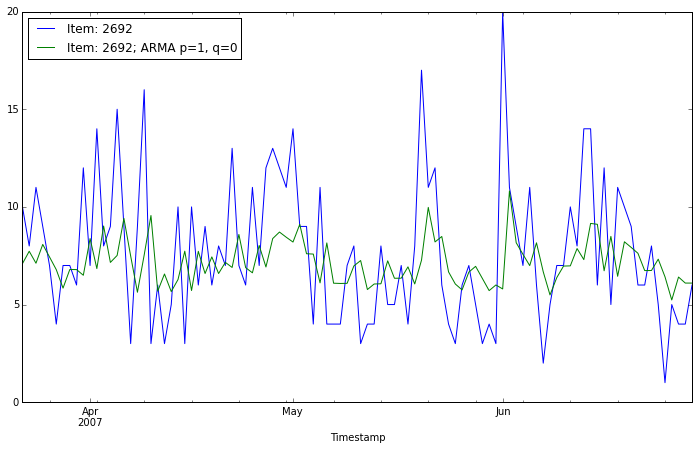

In [ ]:
# ts VS forecast in first 100 steps
model_num = [0]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 4 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[ts.columns[ts_num]+'; '+Models[model]] = frc_ts[ts.columns[ts_num]]

plot_ts.loc[800:900].plot(figsize = (12, 7)) # :250

In [ ]:
# Quality 
print('MACAPE: %.2f'% qualityMACAPE(ts[ts.columns[ts_num]], frc_ts[ts.columns[ts_num]])[0])
print('RMSE: %.1f'% qualityRMSE(ts[ts.columns[ts_num]], frc_ts[ts.columns[ts_num]])[0])

MACAPE: 0.50
RMSE: 3.9


<h1 align="center"> Conclusion </h1>

** Materials **
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - https://onlinecourses.science.psu.edu/stat510/node/62
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Autocorrelation analysis

https://onlinecourses.science.psu.edu/stat510/node/62

http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.acf.html

** HW2 ** 
  * yout fitback about <a href="https://goo.gl/forms/SIa0Elv5PrrEnwwa2"> this seminar </a>